[View in Colaboratory](https://colab.research.google.com/github/Tzeny/cifar100/blob/master/Cifar100.ipynb)

This is my attempt at solving the Cifar100 challenge. This file is also available on GitHub: [https://github.com/Tzeny/cifar10/blob/master/Cifar10.ipynb](https://github.com/Tzeny/cifar10/blob/master/Cifar10.ipynb)



|Nr. crt.|Model architecture | Optimizer | Batch size  | Train images | Stop epoch | Test accuracy |
|---||------------- |---|-------------|----|
|1|2 x inception(w dr 3,36) 2 x (conv(144ft)+maxpool) flt 2 x dense (w dr) act \[w batch normalization\]|Adam(0.001)|128|Normalized color |~20|~93 %

>[Google Colab ensure we have our own GPU](#scrollTo=nZ-oiI4YlXGL)

>[Connecting to Google Drive](#scrollTo=sqKMRov-lQjI)

>[Prepare our dataset](#scrollTo=l-LAEOiUmMgt)

>[Model definition and training](#scrollTo=xmoQDAurmSbS)

>[Model evaluation](#scrollTo=f53m3bg_p5rk)



# Google Colab ensure we have our own GPU

In [4]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.6 GB  | Proc size: 139.9 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


In [0]:
 !kill -9 -1

# Connecting to Google Drive

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p my_drive
!google-drive-ocamlfuse my_drive
!ls my_drive/ai


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
kaggle	projects


# Prepare our dataset

In [84]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

np.random.seed(451)

from keras.datasets import cifar100

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# print shape of data while model is building
print("{1} train samples, {2} channel{0}, {3}x{4}".format("" if X_train.shape[1] == 1 else "s", *X_train.shape))
print("{1}  test samples, {2} channel{0}, {3}x{4}".format("" if X_test.shape[1] == 1 else "s", *X_test.shape))

#capital letter values will be used for the generators
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2)

Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(y_test)
Y_valid_cat = to_categorical(Y_valid)

50000 train samples, 32 channels, 32x3
10000  test samples, 32 channels, 32x3


In [54]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvf cifar-100-python.tar.gz

--2018-07-12 11:03:36--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  5.04MB/s    in 43s     

2018-07-12 11:04:19 (3.74 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [0]:
train = unpickle('cifar-100-python/train')
test = unpickle('cifar-100-python/test')

meta = unpickle('cifar-100-python/meta')

In [0]:
classes = meta[b'fine_label_names']

In [13]:
print(X_train.shape,X_valid.shape,x_test.shape)
print(Y_train_cat.shape,Y_valid_cat.shape,Y_test_cat.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


b'clock'


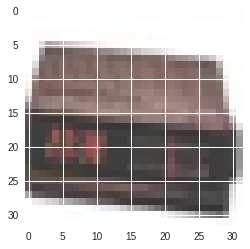

In [91]:
import random
i = random.randint(0,10000)

print(classes[np.argmax(Y_valid_cat[i])])
plt.imshow(X_valid[i])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255 )

valid = generator.flow(X_valid,Y_valid_cat,batch_size = 64)

test = generator.flow(x_test,Y_test_cat,batch_size = 64)

generator2 = ImageDataGenerator(rescale = 1./255)

train = generator2.flow(X_train,Y_train_cat,batch_size = 64)

# Model definition and training

In [96]:
np.random.seed(451)

import datetime

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate, AveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model

def build_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, (1,1), padding='same', activation='relu', 
                     kernel_regularizer=regularization, name='tower_%d_%dx%da'%(tower_nr, shape[0], shape[1]))(input_layer)
    tower = Conv2D(features_nr*2, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, name='tower_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(tower)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, 
                   name='tower_simple_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(input_layer)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_simple_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, 
                           regularization='l2', dropout_ratio=0.2, use_maxpool=True):  
    #feature_nr is an array we'll use to build our layers
    #data is in the form: [1x1, 3x3 reduce, 3x3, 5x5 reduce, 5x5, pool proj]
  
    inception_1x1 = Conv2D(features_nr[0],1,1,border_mode='same',activation='relu',name='inception_%d_/1x1'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_3x3_reduce = Conv2D(features_nr[1],1,1,border_mode='same',activation='relu',name='inception_%d_/3x3_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_3x3 = Conv2D(features_nr[2],3,3,border_mode='same',activation='relu',name='inception_%d_/3x3'%(module_nr),W_regularizer=l2(0.0002))(inception_3x3_reduce)
    
    inception_5x5_reduce = Conv2D(features_nr[3],1,1,border_mode='same',activation='relu',name='inception_%d_/5x5_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_5x5 = Conv2D(features_nr[4],5,5,border_mode='same',activation='relu',name='inception_%d_/5x5'%(module_nr),W_regularizer=l2(0.0002))(inception_5x5_reduce)
    
    inception_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),border_mode='same',name='inception_%d_/pool'%(module_nr))(input_layer)
    
    inception_pool_proj = Conv2D(features_nr[5],1,1,border_mode='same',activation='relu',name='inception_%d_/pool_proj'%(module_nr),W_regularizer=l2(0.0002))(inception_pool)
    
    inception_output = concatenate([inception_1x1,inception_3x3,inception_5x5,inception_pool_proj],axis=3,name='inception_%d_/output'%(module_nr))

    if dropout:
        inception_output = Dropout(dropout_ratio, name='inception_%d_/output_drop'%(module_nr))(inception_output)
    if normalization:
        inception_output = BatchNormalization(name='inception_%d_/output_norm'%(module_nr))(inception_output)

    if use_maxpool:
      inception_output = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(inception_output)
    
    return inception_output

i='cifar100-nrcrt2-'+datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

!mkdir -p models
!mkdir -p logs

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_loss', filepath='./models/'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#saves a log file for tensorboard; remember to save different runs to different subdirectories

#we'll use this instead of decay
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------model definition-------------------

use_norm = True
lrate = 0.001

input_img = Input(shape = (32, 32, 3), name='input')

#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
               # kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

#hopefully this will learn a good internal representation of the image channels
#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
                #kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

inception_1 = build_inception_module(input_img, [64,96,128,16,32,32], 1, True, use_norm)

inception_2 = build_inception_module(inception_1, [128,128,192,32,96,64], 2, True, use_norm)

inception_3 = build_inception_module(inception_2, [192,96,208,16,48,64], 3, True, use_norm)

#tower_3 = build_simple_tower(inception_2, 144, (3,3),  3, False, use_norm)
#tower_4 = build_simple_tower_subsample(tower_3, 144, (3,3), 4, False, use_norm)

#tower_5 = build_simple_tower(tower_4, 288, (3,3),  5, False, use_norm)
#tower_6 = build_simple_tower_subsample(tower_5, 288, (3,3), 6, False, use_norm)

#model top

flat_pool = AveragePooling2D(pool_size=(4, 4), padding='valid')(inception_3)

flat = Flatten()(flat_pool)


dense_5 = build_dense(flat, 128, 1, True, use_norm)

dense_6 = build_dense(dense_5, 64, 2, True, use_norm)

out = Dense(100, activation='softmax')(dense_6)

model = Model(inputs = input_img, outputs = out)

#-----------------------------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lrate),
              metrics=['accuracy'])

model.summary()

model_json = model.to_json()
with open("./models/"+str(i)+".json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to" + "../models/"+str(i)+".json")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", name="inception_1_/1x1", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (1, 1), activation="relu", name="inception_1_/3x3_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="inception_1_/3x3", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", name="inception_1_/5x5_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
inception_1_/3x3_reduce (Conv2D (None, 32, 32, 96)   384         input[0][0]                      
__________________________________________________________________________________________________
inception_1_/5x5_reduce (Conv2D (None, 32, 32, 16)   64          input[0][0]                      
__________________________________________________________________________________________________
inception_1_/pool (MaxPooling2D (None, 32, 32, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
inception_

In [97]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
  
print("Memory usage (GB):", get_model_memory_usage(128,model))

Memory usage (GB): 1.439


In [98]:
import tensorflow as tf

with tf.device('/gpu:0'):
  model.fit_generator(generator=train,
                      validation_data=valid,
                      steps_per_epoch=2000,
                      epochs=50,
                      verbose=1,callbacks=callbacks)  # starts training

result = model.evaluate_generator(test)

print("Accuracy on test set: ",result[1]*100,"%")

#copy our generated model and logs to GoogleDrive
!cp -R models my_drive/ai/projects/cifar100
!cp -R logs my_drive/ai/projects/cifar100

print("Copied model and logs to Google Drive")

Epoch 1/50
1999/2000 [============================>.] - ETA: 0s - loss: 4.2657 - acc: 0.1187

2000/2000 [==============================] - 301s 150ms/step - loss: 4.2654 - acc: 0.1187 - val_loss: 4.1352 - val_acc: 0.1080

Epoch 00001: val_loss improved from inf to 4.13520, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 2/50
 235/2000 [==>...........................] - ETA: 4:17 - loss: 3.5188 - acc: 0.1932

1999/2000 [============================>.] - ETA: 0s - loss: 3.3263 - acc: 0.2362

2000/2000 [==============================] - 299s 149ms/step - loss: 3.3262 - acc: 0.2362 - val_loss: 3.5125 - val_acc: 0.2021

Epoch 00002: val_loss improved from 4.13520 to 3.51246, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 3/50
 232/2000 [==>...........................] - ETA: 4:17 - loss: 3.1371 - acc: 0.2766

1999/2000 [============================>.] - ETA: 0s - loss: 3.0621 - acc: 0.2945

2000/2000 [==============================] - 298s 149ms/step - loss: 3.0620 - acc: 0.2946 - val_loss: 3.5015 - val_acc: 0.2282

Epoch 00003: val_loss improved from 3.51246 to 3.50152, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 4/50
 232/2000 [==>...........................] - ETA: 4:17 - loss: 3.0009 - acc: 0.3151

1999/2000 [============================>.] - ETA: 0s - loss: 2.9191 - acc: 0.3319

2000/2000 [==============================] - 299s 149ms/step - loss: 2.9190 - acc: 0.3319 - val_loss: 3.2686 - val_acc: 0.2799

Epoch 00004: val_loss improved from 3.50152 to 3.26859, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 5/50
 232/2000 [==>...........................] - ETA: 4:18 - loss: 2.8417 - acc: 0.3519

1999/2000 [============================>.] - ETA: 0s - loss: 2.8185 - acc: 0.3574

2000/2000 [==============================] - 299s 149ms/step - loss: 2.8185 - acc: 0.3574 - val_loss: 3.5001 - val_acc: 0.2369

Epoch 00005: val_loss did not improve from 3.26859
Epoch 6/50
 365/2000 [====>.........................] - ETA: 3:58 - loss: 2.7628 - acc: 0.3729

1999/2000 [============================>.] - ETA: 0s - loss: 2.7469 - acc: 0.3771

2000/2000 [==============================] - 298s 149ms/step - loss: 2.7469 - acc: 0.3770 - val_loss: 3.1567 - val_acc: 0.3125

Epoch 00006: val_loss improved from 3.26859 to 3.15667, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 7/50
 232/2000 [==>...........................] - ETA: 4:17 - loss: 2.6945 - acc: 0.3869

1999/2000 [============================>.] - ETA: 0s - loss: 2.6886 - acc: 0.3914

2000/2000 [==============================] - 299s 149ms/step - loss: 2.6886 - acc: 0.3914 - val_loss: 3.2248 - val_acc: 0.2894

Epoch 00007: val_loss did not improve from 3.15667
Epoch 8/50
 365/2000 [====>.........................] - ETA: 3:58 - loss: 2.6821 - acc: 0.3994

1999/2000 [============================>.] - ETA: 0s - loss: 2.6444 - acc: 0.4035

2000/2000 [==============================] - 299s 149ms/step - loss: 2.6444 - acc: 0.4035 - val_loss: 3.0028 - val_acc: 0.3429

Epoch 00008: val_loss improved from 3.15667 to 3.00279, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 9/50
 232/2000 [==>...........................] - ETA: 4:18 - loss: 2.6524 - acc: 0.4075

1999/2000 [============================>.] - ETA: 0s - loss: 2.6114 - acc: 0.4137

2000/2000 [==============================] - 298s 149ms/step - loss: 2.6113 - acc: 0.4138 - val_loss: 3.2116 - val_acc: 0.3036

Epoch 00009: val_loss did not improve from 3.00279
Epoch 10/50
 364/2000 [====>.........................] - ETA: 3:57 - loss: 2.5875 - acc: 0.4210

1999/2000 [============================>.] - ETA: 0s - loss: 2.5809 - acc: 0.4214

2000/2000 [==============================] - 298s 149ms/step - loss: 2.5808 - acc: 0.4214 - val_loss: 2.9458 - val_acc: 0.3558

Epoch 00010: val_loss improved from 3.00279 to 2.94576, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 11/50
 231/2000 [==>...........................] - ETA: 4:17 - loss: 2.5235 - acc: 0.4342

1999/2000 [============================>.] - ETA: 0s - loss: 2.5465 - acc: 0.4331

2000/2000 [==============================] - 298s 149ms/step - loss: 2.5464 - acc: 0.4331 - val_loss: 2.9643 - val_acc: 0.3527

Epoch 00011: val_loss did not improve from 2.94576
Epoch 12/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 2.5469 - acc: 0.4374

1999/2000 [============================>.] - ETA: 0s - loss: 2.5248 - acc: 0.4395

2000/2000 [==============================] - 297s 148ms/step - loss: 2.5247 - acc: 0.4395 - val_loss: 3.1614 - val_acc: 0.3128

Epoch 00012: val_loss did not improve from 2.94576
Epoch 13/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 2.5497 - acc: 0.4355

1999/2000 [============================>.] - ETA: 0s - loss: 2.5059 - acc: 0.4452

2000/2000 [==============================] - 298s 149ms/step - loss: 2.5059 - acc: 0.4452 - val_loss: 3.1679 - val_acc: 0.3167

Epoch 00013: val_loss did not improve from 2.94576
Epoch 14/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 2.4963 - acc: 0.4471

1999/2000 [============================>.] - ETA: 0s - loss: 2.4876 - acc: 0.4506

2000/2000 [==============================] - 298s 149ms/step - loss: 2.4877 - acc: 0.4506 - val_loss: 3.0471 - val_acc: 0.3388

Epoch 00014: val_loss did not improve from 2.94576
Epoch 15/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 2.4609 - acc: 0.4605

1999/2000 [============================>.] - ETA: 0s - loss: 2.4703 - acc: 0.4575

2000/2000 [==============================] - 298s 149ms/step - loss: 2.4704 - acc: 0.4574 - val_loss: 3.2161 - val_acc: 0.3154

Epoch 00015: val_loss did not improve from 2.94576
Epoch 16/50
 279/2000 [===>..........................] - ETA: 4:09 - loss: 2.2858 - acc: 0.4983

1999/2000 [============================>.] - ETA: 0s - loss: 2.1324 - acc: 0.5306

2000/2000 [==============================] - 298s 149ms/step - loss: 2.1324 - acc: 0.5306 - val_loss: 2.8119 - val_acc: 0.3869

Epoch 00016: val_loss improved from 2.94576 to 2.81186, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 17/50
 232/2000 [==>...........................] - ETA: 4:18 - loss: 1.9893 - acc: 0.5560

1999/2000 [============================>.] - ETA: 0s - loss: 1.9459 - acc: 0.5643

2000/2000 [==============================] - 298s 149ms/step - loss: 1.9458 - acc: 0.5643 - val_loss: 2.8124 - val_acc: 0.3787

Epoch 00017: val_loss did not improve from 2.81186
Epoch 18/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 1.9074 - acc: 0.5650

1999/2000 [============================>.] - ETA: 0s - loss: 1.8646 - acc: 0.5739

2000/2000 [==============================] - 298s 149ms/step - loss: 1.8646 - acc: 0.5739 - val_loss: 2.7401 - val_acc: 0.3889

Epoch 00018: val_loss improved from 2.81186 to 2.74011, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 19/50
 232/2000 [==>...........................] - ETA: 4:18 - loss: 1.8133 - acc: 0.5849

1999/2000 [============================>.] - ETA: 0s - loss: 1.7853 - acc: 0.5887

2000/2000 [==============================] - 298s 149ms/step - loss: 1.7852 - acc: 0.5887 - val_loss: 2.7499 - val_acc: 0.3830

Epoch 00019: val_loss did not improve from 2.74011
Epoch 20/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 1.7555 - acc: 0.5924

1999/2000 [============================>.] - ETA: 0s - loss: 1.7383 - acc: 0.5941

2000/2000 [==============================] - 298s 149ms/step - loss: 1.7380 - acc: 0.5942 - val_loss: 2.7171 - val_acc: 0.3848

Epoch 00020: val_loss improved from 2.74011 to 2.71710, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 21/50
 232/2000 [==>...........................] - ETA: 4:17 - loss: 1.7148 - acc: 0.5962

1999/2000 [============================>.] - ETA: 0s - loss: 1.6950 - acc: 0.6018

2000/2000 [==============================] - 298s 149ms/step - loss: 1.6949 - acc: 0.6019 - val_loss: 2.6815 - val_acc: 0.3924

Epoch 00021: val_loss improved from 2.71710 to 2.68147, saving model to ./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5
Epoch 22/50
 232/2000 [==>...........................] - ETA: 4:18 - loss: 1.6767 - acc: 0.6070

1999/2000 [============================>.] - ETA: 0s - loss: 1.6617 - acc: 0.6072

2000/2000 [==============================] - 298s 149ms/step - loss: 1.6617 - acc: 0.6072 - val_loss: 2.7635 - val_acc: 0.3805

Epoch 00022: val_loss did not improve from 2.68147
Epoch 23/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 1.6530 - acc: 0.6045

1999/2000 [============================>.] - ETA: 0s - loss: 1.6279 - acc: 0.6125

2000/2000 [==============================] - 298s 149ms/step - loss: 1.6280 - acc: 0.6125 - val_loss: 2.7361 - val_acc: 0.3831

Epoch 00023: val_loss did not improve from 2.68147
Epoch 24/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 1.6169 - acc: 0.6189

1999/2000 [============================>.] - ETA: 0s - loss: 1.6028 - acc: 0.6191

2000/2000 [==============================] - 298s 149ms/step - loss: 1.6028 - acc: 0.6191 - val_loss: 2.7213 - val_acc: 0.3849

Epoch 00024: val_loss did not improve from 2.68147
Epoch 25/50
 364/2000 [====>.........................] - ETA: 3:57 - loss: 1.5804 - acc: 0.6215

1999/2000 [============================>.] - ETA: 0s - loss: 1.5819 - acc: 0.6221

2000/2000 [==============================] - 298s 149ms/step - loss: 1.5819 - acc: 0.6221 - val_loss: 2.6984 - val_acc: 0.3903

Epoch 00025: val_loss did not improve from 2.68147
Epoch 26/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 1.5643 - acc: 0.6277

1999/2000 [============================>.] - ETA: 0s - loss: 1.5573 - acc: 0.6276

2000/2000 [==============================] - 299s 149ms/step - loss: 1.5574 - acc: 0.6276 - val_loss: 2.7332 - val_acc: 0.3809

Epoch 00026: val_loss did not improve from 2.68147
Epoch 27/50
 364/2000 [====>.........................] - ETA: 3:59 - loss: 1.5306 - acc: 0.6325

1999/2000 [============================>.] - ETA: 0s - loss: 1.5112 - acc: 0.6386

2000/2000 [==============================] - 298s 149ms/step - loss: 1.5113 - acc: 0.6386 - val_loss: 2.6924 - val_acc: 0.3894

Epoch 00027: val_loss did not improve from 2.68147
Epoch 28/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 1.4985 - acc: 0.6428

1999/2000 [============================>.] - ETA: 0s - loss: 1.4895 - acc: 0.6450

2000/2000 [==============================] - 299s 149ms/step - loss: 1.4896 - acc: 0.6450 - val_loss: 2.6998 - val_acc: 0.3890

Epoch 00028: val_loss did not improve from 2.68147
Epoch 29/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 1.4855 - acc: 0.6458

1999/2000 [============================>.] - ETA: 0s - loss: 1.4795 - acc: 0.6468

2000/2000 [==============================] - 298s 149ms/step - loss: 1.4795 - acc: 0.6468 - val_loss: 2.7008 - val_acc: 0.3906

Epoch 00029: val_loss did not improve from 2.68147
Epoch 30/50
 364/2000 [====>.........................] - ETA: 3:58 - loss: 1.4677 - acc: 0.6517

1999/2000 [============================>.] - ETA: 0s - loss: 1.4651 - acc: 0.6519

2000/2000 [==============================] - 298s 149ms/step - loss: 1.4651 - acc: 0.6519 - val_loss: 2.6961 - val_acc: 0.3912

Epoch 00030: val_loss did not improve from 2.68147
Epoch 31/50
 364/2000 [====>.........................] - ETA: 3:59 - loss: 1.4702 - acc: 0.6465

1999/2000 [============================>.] - ETA: 0s - loss: 1.4636 - acc: 0.6493

2000/2000 [==============================] - 298s 149ms/step - loss: 1.4636 - acc: 0.6493 - val_loss: 2.7162 - val_acc: 0.3860

Epoch 00031: val_loss did not improve from 2.68147
Epoch 00031: early stopping
Accuracy on test set:  39.589999999999996 %
Copied model and logs to Google Drive


# Model evaluation

In [0]:
model.load_weights('./models/cifar10-nrcrt10-03:02PM_July-11-2018.hdf5')

result = model.evaluate_generator(test)

print(result)

10000/10000 [==============================] - 8s 837us/step
[0.12198813806772232, 0.9664000005722045]
